# Import libraries

In [ ]:
import pandas as pd
import random
import re
from pylatexenc.latex2text import LatexNodes2Text
import matplotlib.pyplot as plt
import seaborn as sns

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Update Dataset

In [ ]:
url = '../Dataset/cs_papers_api.csv'
# Load the dataset from CSV file

df = pd.read_csv(url)

# Cleaning of the dataset

In [ ]:
new_text = df.loc[130,"abstract"][:-1] + '}' + df.loc[130,"abstract"][-1:] # In the text miss a graph parentesis

# Update the DataFrame
df.loc[130, "abstract"] = new_text

In [ ]:
def extract_latex_formulas(text):
    """
    Extracts LaTeX mathematical formulas from a given text.

    This function identifies and extracts text segments that represent LaTeX-formatted
    mathematical expressions. It covers the four most common types of formula delimiters:

    - Inline formulas: enclosed by single dollar signs `$...$`
    - Display formulas: enclosed by double dollar signs `$$...$$`
    - Equation environment: `\begin{equation}...\end{equation}`
    - Align environment: `\begin{align}...\end{align}`

    Args:
        text (str): The input string, a scientific abstract.

    Returns:
        list: A list of strings, each representing LaTeX formulas found in the text.
    """
    # $$...$$
    display_pattern = re.findall(r'\$\$[^$].*?\$\$', text, flags=re.DOTALL)

    # $...$
    inline_pattern = re.findall(r'\$[^$][^$\n]*?\$', text, flags=re.DOTALL)

    # \( ... \)
    text = re.sub(r'\\\((.*?)\\\)', '[FORMULA]', text)

    # \[...\]
    text = re.sub(r'\\\[(.*?)\\\]', '[FORMULA]', text)

    # Equation environment: \begin{equation}...\end{equation}
    equation_pattern = re.findall(r'\\begin{equation}.*?\\end{equation}', text, flags=re.DOTALL)

    # align environment: \begin{align}...\end{align}
    align_pattern = re.findall(r'\\begin{align}.*?\\end{align}', text, flags=re.DOTALL)

    return inline_pattern + display_pattern + equation_pattern + align_pattern

# Apply the function to each abstract in the dataset
row_formulas = df['abstract'].apply(extract_latex_formulas)

# Count how many abstracts contain at least one LaTeX formula
num_with_formulas = row_formulas.apply(len).gt(0).sum()
print(f"Number of abstracts containing at least one formula: {num_with_formulas} out of {len(df)}")

# Flatten the list of lists to get all formulas across all abstracts
all_formulas = [formula for sublist in row_formulas for formula in sublist]

print(f"Total number of extracted formulas: {len(all_formulas)}")


Number of abstracts containing at least one formula: 26236 out of 200094
Total number of extracted formulas: 182900


In [ ]:
def replace_latex_formulas(text):
    """
    Replaces all LaTeX mathematical formulas within a text with a placeholder token.

    This function detects LaTeX-formatted formulas written in one of the following formats:

    - Inline formulas: `$...$`
    - Display formulas: `$$...$$`
    - LaTeX environments: `\begin{equation}...\end{equation}` and `\begin{align}...\end{align}`

    Each formula is replaced with the string `[FORMULA]` to simplify downstream text processing.
    The use of `re.DOTALL` allows matching across multiple lines, which is necessary for
    environments that may span several lines of text.

    Returns:
        str: A cleaned version of the input text with formulas replaced by [FORMULA].
    """

    # Replace display formulas: $$...$$
    text = re.sub(r'\$\$[^$].*?\$\$', "[FORMULA]", text, flags=re.DOTALL)

    # Replace inline formulas: $...$
    text = re.sub(r'\$[^$][^$\n]*?\$', "[FORMULA]", text, flags=re.DOTALL)

    # Inline math: \( ... \)
    text = re.sub(r'\\\((.*?)\\\)', '[FORMULA]', text)

    # Display math: \[...\]
    text = re.sub(r'\\\[(.*?)\\\]', '[FORMULA]', text)

    # Replace equation environment: \begin{equation}...\end{equation}
    text = re.sub(r"\\begin{equation}.*?\\end{equation}", "[FORMULA]", text, flags=re.DOTALL)

    # Replace align environment: \begin{align}...\end{align}
    text = re.sub(r"\\begin{align}.*?\\end{align}", "[FORMULA]", text, flags=re.DOTALL)

    return text

# Apply formula replacement to the 'abstract' column
df['abstract_clean'] = df['abstract'].apply(replace_latex_formulas)

# Re-check if any LaTeX formulas remain after cleaning
row_formulas = df['abstract_clean'].apply(extract_latex_formulas)

# Count how many cleaned abstracts still contain LaTeX formulas (ideally should be 0)
num_con_formulas = row_formulas.apply(len).gt(0).sum()
print(f"Number of abstracts still containing formulas after cleaning: {num_con_formulas} out of {len(df)}")


Number of abstracts still containing formulas after cleaning: 0 out of 200094


In [ ]:
def extract_latex_links(text):
    r"""
    Extracts all hyperlinks from a LaTeX-formatted text, including:

    - \url{...}
    - \href{URL}{label}
    - Direct URLs starting with http or https

    Returns:
        list of str: A list of all link occurrences found in the input text.
    """
    # Match \href{url}{text}
    href_links = re.findall(r'\\ref\{[^}]*\}', text)

    # Match \url{...}
    latex_links = re.findall(r'\\url\{[^}]*\}', text)

    # Match direct links like https://...
    direct_links = re.findall(r'https?://[^\s{}()\[\],;]+', text)

    return latex_links + direct_links + href_links

# Apply link extraction to each abstract
row_links = df['abstract_clean'].apply(extract_latex_links)

# Count number of abstracts containing at least one link
num_con_links = row_links.apply(len).gt(0).sum()
print(f"Abstracts with at least one link: {num_con_links} out of {len(df)}")

# Flatten all links into a single list
all_links = [link for sublist in row_links for link in sublist]
print(f"Total number of links extracted: {len(all_links)}")


Abstracts with at least one link: 5311 out of 200094
Total number of links extracted: 6036


In [ ]:
def replace_latex_links(text):
    r"""
    Replaces all hyperlinks in LaTeX format or raw URLs with a placeholder [LINK].

    Handles:
    - \href{URL}{label}
    - \url{URL}
    - Direct links (http:// or https://)

    Returns:
        str: The input text with links replaced.
    """
    # Replace \href{url}{label} with [LINK]
    text = re.sub(r'\\ref\{[^}]*\}', '[LINK]', text)

    # Replace \url{...} with [LINK]
    text = re.sub(r'\\url\{[^}]*\}', '[LINK]', text)

    # Replace direct links (http:// or https://) with [LINK]
    text = re.sub(r'https?://[^\s{}()\[\],;]+', '[LINK]', text)

    return text

# Apply the link removal to all abstracts
df['abstract_clean'] = df['abstract_clean'].apply(replace_latex_links)

# Check how many abstracts still contain links (should be 0 ideally)
row_links = df['abstract_clean'].apply(extract_latex_links)
num_con_links = row_links.apply(len).gt(0).sum()

print(f"Abstracts with at least one link: {num_con_links} out of {len(df)}")


Abstracts with at least one link: 0 out of 200094


In [ ]:
def extract_latex_bars(text):
    """
    Extract all occurrences of double hyphens '--' from the input text.

    Returns:
        list: A list containing all instances of double hyphens found in the text.
    """
    # Use regex to find all occurrences of '--' in the text
    return re.findall(r'--', text)

# Apply the extraction function to the 'abstract_clean' column of the DataFrame
row_bars = df['abstract_clean'].apply(extract_latex_bars)

# Count how many abstracts contain at least one double hyphen
num_with_bars = row_bars.apply(len).gt(0).sum()

print(f"Abstracts containing '--': {num_with_bars} out of {len(df)}")


Abstracts containing '--': 8502 out of 200094


In [ ]:
def replace_latex_bars(text):
    """
    Replace all occurrences of double hyphens '--' with commas ','.

    Args:
        text (str): Input string possibly containing '--'.

    Returns:
        str: Modified string with '--' replaced by ','.
    """
    return re.sub(r'--', ',', text)

# Apply the replacement to the 'abstract_clean' column
df['abstract_clean'] = df['abstract_clean'].apply(replace_latex_bars)

# Apply the extraction function to the 'abstract_clean' column of the DataFrame
row_bars = df['abstract_clean'].apply(extract_latex_bars)

# Count how many abstracts contain at least one double hyphen
num_with_bars = row_bars.apply(len).gt(0).sum()

print(f"Abstracts containing '--': {num_with_bars} out of {len(df)}")


Abstracts containing '--': 0 out of 200094


In [ ]:
def extract_latex_bullets_lists(text):
    """
    Extract LaTeX bullet list commands from the input text.

    Specifically matches the LaTeX environment start for itemized lists: \begin{itemize}.


    Returns
        list: A list of all occurrences of the itemized list opening command.
    """
    # Match occurrences of the LaTeX itemize environment opening
    return re.findall(r'\\begin\{itemize\}', text)

# Apply the extraction function to the 'abstract_clean' column
row_bullets_lists = df['abstract_clean'].apply(extract_latex_bullets_lists)

# Count how many abstracts contain at least one bullet list
num_with_bullets = row_bullets_lists.apply(len).gt(0).sum()
print(f"Abstracts with at least one bullet list: {num_with_bullets} out of {len(df)}")

# Flatten the list to obtain all extracted bullet list commands
all_bullets_lists = [cmd for sublist in row_bullets_lists for cmd in sublist]
print(f"Total number of bullet list commands extracted: {len(all_bullets_lists)}")


Abstracts with at least one bullet list: 10 out of 200094
Total number of bullet list commands extracted: 10


In [ ]:
def replace_latex_bullets_lists(text):
    r"""
    Removes LaTeX bullet list commands from the input text.

    Specifically removes:
    - \begin{itemize}
    - \end{itemize}
    - \item


    Returns
        str: The cleaned string without LaTeX list formatting.
    """
    text = re.sub(r'\\begin\{itemize\}', '', text)
    text = re.sub(r'\\end\{itemize\}', '', text)
    text = re.sub(r'\\item', '', text)
    return text

# Apply the replacement function to the dataset
df['abstract_clean'] = df['abstract_clean'].apply(replace_latex_bullets_lists)

# Re-check for any remaining bullet list commands
row_bullets_lists = df['abstract_clean'].apply(extract_latex_bullets_lists)
num_with_bullets = row_bullets_lists.apply(len).gt(0).sum()

print(f"Abstracts with at least one bullet list command: {num_with_bullets} out of {len(df)}")

Abstracts with at least one bullet list command: 0 out of 200094


In [ ]:
def extract_latex_backslash(text):
    """
    Extracts all backslashes from the input text.

    Backslashes are used to indicate LaTeX commands and escape sequences.

    Returns
        list: A list of all backslashes found in the text.
    """
    return re.findall(r"\\", text)

# Apply the extraction function to each abstract
row_backslash = df['abstract_clean'].apply(extract_latex_backslash)

# Count how many abstracts still contain at least one backslash
num_with_backslash = row_backslash.apply(len).gt(0).sum()
print(f"Abstracts with at least one backslash: {num_with_backslash} out of {len(df)}")

# Flatten the list of all extracted backslashes
all_backslash = [b for sublist in row_backslash for b in sublist]
print(f"Total number of backslashes extracted: {len(all_backslash)}")


Abstracts with at least one backslash: 14375 out of 200094
Total number of backslashes extracted: 33798


In [ ]:
def replace_latex_commands(text):
    r"""
    Cleans LaTeX-specific commands and replaces them with appropriate plain text equivalents.

    Handles:
    - \emph{}, \textit{}, \textbf{}, \underline{}: preserves the inner content
    - \em, \cite{}: removes the command and/or content
    - Replaces common LaTeX accented characters with Unicode equivalents

    Returns
        str: Text with LaTeX commands replaced or removed.
    """
    # Preserve inner content for text formatting commands
    text = re.sub(r'\\emph\{([^}]+)\}', r'\1', text)
    text = re.sub(r'\\textit\{([^}]+)\}', r'\1', text)
    text = re.sub(r'\\textbf\{([^}]+)\}', r'\1', text)
    text = re.sub(r'\\underline\{([^}]+)\}', r'\1', text)

    # Remove inline emphasis command (e.g., \em text)
    text = re.sub(r'\\em\s*', '', text)

    # Remove citation commands entirely
    text = re.sub(r'\\cite\{[^}]+\}', '', text)

    text = re.sub(r'\\colorb\{([^}]*)\}', r'\1', text)

    # Replace common LaTeX-encoded accented characters with Unicode equivalents
    latex_accents = {
        r"\\'a": "á", r"\\'e": "é", r"\\'i": "í", r"\\'o": "ó", r"\\'u": "ú",
        r'\\"a': "ä", r'\\"e': "ë", r'\\"i': "ï", r'\\"o': "ö", r'\\"u': "ü",
        r"\\`a": "à", r"\\`e": "è", r"\\`i": "ì", r"\\`o": "ò", r"\\`u": "ù",
        r"\\^a": "â", r"\\^e": "ê", r"\\^i": "î", r"\\^o": "ô", r"\\^u": "û",
        r"\\~n": "ñ", r"\\H\{o\}": "ő", r"\\H\{u\}": "ű", r"\\'{e}": "é", r"\\'{o}": "ó",
        r"\\'{u}": "ú", r"\\'{i}": "í", r"\\'{a}": "á",
    }
    for latex, replacement in latex_accents.items():
        text = re.sub(latex, replacement, text)

    replacements = {
        r'\\#': '#',
        r'\\%': '%',
        r'\\&': '&',
        r"\\'": "'",
        r"\\`": "`",
        r'\\~': "~",
        r'\\\^': "^"
    }
    for pattern, replacement in replacements.items():
        text = re.sub(pattern, replacement, text)

    return text

# Apply the command replacement to each abstract
df['abstract_clean'] = df['abstract_clean'].apply(replace_latex_commands)

# Check for any remaining backslashes (indicating unresolved LaTeX commands)
row_backslash = df['abstract_clean'].apply(extract_latex_backslash)
num_con_commands = row_backslash.apply(len).gt(0).sum()

print(f"Abstracts with at least one backslash: {num_con_commands} out of {len(df)}")


Abstracts with at least one backslash: 4668 out of 200094


The row 15 present a special command \\model. By examining the original abstract, I found that the command takes the value DANLIP, and thus I proceed with its replacement

In [ ]:
df.loc[15, 'abstract_clean'] = df.loc[15, 'abstract_clean'].replace(r"\model", "DANLIP")

df.loc[9819, 'abstract_clean'] = df.loc[15, 'abstract_clean'].replace(r"\method", "TopoImb")

df.loc[10209, 'abstract_clean'] = df.loc[15, 'abstract_clean'].replace(r"\model", "LSM")

df.loc[10366, 'abstract_clean'] = df.loc[15, 'abstract_clean'].replace(r"\ourmodel", "PHN-HVI")

In [ ]:
def clean_latex_commands(text):
    """
    Cleans LaTeX markup and formatting from a scientific text string.

    This function removes or replaces common LaTeX commands, special characters,
    and formatting patterns to produce clean, plain text suitable for NLP tasks.

    Returns:
        str: The cleaned version of the input string, with LaTeX commands stripped or replaced.
    """
    # 1. Remove LaTeX commands that include arguments in braces, e.g., \citep{...}
    commands_to_remove = ['citep', 'citet', 'footnote', 'color', 'mbox','cite']
    for cmd in commands_to_remove:
        text = re.sub(rf'\\{cmd}\{{[^}}]*\}}', '', text)

    # 2. Unwrap commands like \texttt{word} → word
    unwrap_commands = ['texttt', 'textsc', 'textsf', 'textsl', 'ul', 'gls', 'glspl', 'uline', 'revision']
    for cmd in unwrap_commands:
        text = re.sub(rf'\\{cmd}\{{([^}}]*)\}}', r'\1', text)

    # 3. Replace common LaTeX shortcuts or symbols
    replacements = {
        r'\\deg': '°',
        r'\\eps\b': 'ε',
        r'\\ie\b': 'i.e.',
        r'\\eg\b': 'e.g.',
        r'\\iid\b': 'i.i.d.',
        r'\\"{o}': 'ó',
        r'\\ll\b': '≪',
        r'\\dots(?=\w)': '',       # \dotsword → word
        r'~\\ie\b': 'i.e.',
        r'\\ell': 'ell',
    }
    for pattern, repl in replacements.items():
        text = re.sub(pattern, repl, text)

    # 4. Replace escaped special characters
    escapes = {
        r'\\\$': '$',
        r'\\_': '_',
        r'\\,': ' ',
        r'\\:': ':',
        r'\\2': '2',
        r'\\c': 'c',
        r'\\t': 't',
        r'\\P': 'P',
    }
    for pattern, repl in escapes.items():
        text = re.sub(pattern, repl, text)

    # 5. Handle accented letters and special encodings
    text = re.sub(r'na\\"\{i\}ve', 'naïve', text)
    text = re.sub(r'\\v\{a\}', 'ǎ', text)
    text = re.sub(r'\\k\{([^}]+)\}', r'k\1', text)

    # 6. Unwrap grouped formatting, e.g., {\bf text} → text
    text = re.sub(r'\{\\[a-z]+\s*([^}]+)\}', r'\1', text)

    # 7. Remove unwanted standalone LaTeX commands
    text = re.sub(r'\\(s|indent)\b', '', text)

    # 8. Replace hyperlink-style commands with a placeholder
    text = re.sub(r'\\href\s*\{[^}]*\}\{[^}]*\}', '[LINK]', text)
    text = re.sub(r'\\hyperlink\{[^}]*\}\{[^}]*\}', '', text)

    # 9. Replace double backslashes with a single space
    text = re.sub(r'\\\\\s*', ' ', text)

    # 10. Replace known formula pattern with [FORMULA]
    # text = re.sub(r"P\(\|In - I\* \| {\leq} {delta}I\*\) {\leq}", "[FORMULA]", text)
    text = re.sub("P\\(\\|In - I\\* \\| \\{\\\\leq\\} \\{delta\\}I\\*\\) \\{\\\\leq\\}", "[FORMULA]", text)


    return text

# Apply the command replacement to each abstract
df['abstract_clean'] = df['abstract_clean'].apply(clean_latex_commands)

# Check for any remaining backslashes (indicating unresolved LaTeX commands)
row_backslash = df['abstract_clean'].apply(extract_latex_backslash)
num_con_commands = row_backslash.apply(len).gt(0).sum()

print(f"Abstracts with at least one backslash: {num_con_commands} out of {len(df)}")


Abstracts with at least one backslash: 2433 out of 200094


In [ ]:
error_indices = []

def latex_to_plain_with_logging(text, idx=None):
    """
    Converts a LaTeX formatted string into plain text while logging any conversion errors.

    Returns:
        str: The plain text version of the input string. If an error occurs, returns an empty string.
    """
    if not isinstance(text, str):
        return ""

    try:
        # Convert LaTeX to plain text
        return LatexNodes2Text().latex_to_text(text)
    except Exception as e:
        # Log any errors along with the index of the problematic row
        print(f"[ROW {idx}] Error during LaTeX conversion: {e}")
        error_indices.append(idx)
        return ""


# Apply conversion to all rows in the abstract_clean column
df["plain_abstract"] = [
    latex_to_plain_with_logging(text, idx) for idx, text in enumerate(df["abstract_clean"])
]

# Detect remaining LaTeX-style backslashes in the cleaned abstracts
row_backslash = df['plain_abstract'].apply(extract_latex_backslash)

# Count how many abstracts still contain at least one backslash
num_with_backslash = row_backslash.apply(len).gt(0).sum()
print(f"Abstracts with at least one backslash: {num_with_backslash} out of {len(df)}")

# Flatten all backslashes into a single list
all_backslash = [b for sublist in row_backslash for b in sublist]
print(f"Total number of backslashes extracted: {len(all_backslash)}")

[ROW 18418] Error during LaTeX conversion: list index out of range
[ROW 127553] Error during LaTeX conversion: list index out of range
Abstracts with at least one backslash: 0 out of 200094
Total number of backslashes extracted: 0


In [ ]:
# Righe da modificare (0-based index, quindi 18547 e 126999)
target_rows = [18418, 127553]

# Funzione di pulizia
def clean_text(text):
    if not isinstance(text, str):
        return text
    text = re.sub(r'\$.*?\$', '[FORMULA]', text)
    text = re.sub(r'\\mathbb\{.*?\}', '[FORMULA]', text)
    text = re.sub(r'\\href\{.*?\}\ \{.*?\}', '[LINK]', text)
    text = re.sub(r'\\href\{[^}]*\}', '[LINK]', text)
    return text

# Applica solo alle righe selezionate (su tutte le colonne testuali)
for row in target_rows:
        df.at[row, "plain_abstract"] = clean_text(df.at[row, "abstract_clean"])


In [ ]:
df.loc[127553, "plain_abstract"]

'Training graph neural networks (GNNs) on large graphs is complex and extremely time consuming. This is attributed to overheads caused by sparse matrix multiplication, which are sidestepped when training multi-layer perceptrons (MLPs) with only node features. MLPs, by ignoring graph context, are simple and faster for graph data, however they usually sacrifice prediction accuracy, limiting their applications for graph data. We observe that for most message passing-based GNNs, we can trivially derive an analog MLP (we call this a PeerMLP) with an equivalent weight space, by setting the trainable parameters with the same shapes, making us curious about how do GNNs using weights from a fully trained PeerMLP perform? Surprisingly, we find that GNNs initialized with such weights significantly outperform their PeerMLPs, motivating us to use PeerMLP training as a precursor, initialization step to GNN training. To this end, we propose an embarrassingly simple, yet hugely effective initializatio

In [ ]:
df.loc[127553, "abstract_clean"]

'Training graph neural networks (GNNs) on large graphs is complex and extremely time consuming. This is attributed to overheads caused by sparse matrix multiplication, which are sidestepped when training multi-layer perceptrons (MLPs) with only node features. MLPs, by ignoring graph context, are simple and faster for graph data, however they usually sacrifice prediction accuracy, limiting their applications for graph data. We observe that for most message passing-based GNNs, we can trivially derive an analog MLP (we call this a PeerMLP) with an equivalent weight space, by setting the trainable parameters with the same shapes, making us curious about how do GNNs using weights from a fully trained PeerMLP perform? Surprisingly, we find that GNNs initialized with such weights significantly outperform their PeerMLPs, motivating us to use PeerMLP training as a precursor, initialization step to GNN training. To this end, we propose an embarrassingly simple, yet hugely effective initializatio

In [ ]:
df["abstract_clean"] = df["plain_abstract"]

df = df.drop("plain_abstract", axis=1)

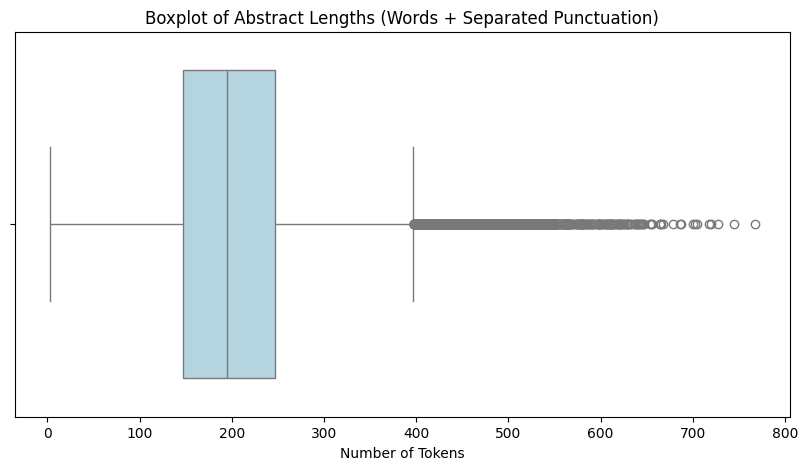

count    200094.000000
mean        200.287460
std          76.802537
min           3.000000
25%         147.000000
50%         195.000000
75%         247.000000
max         767.000000
Name: abstract, dtype: float64


In [ ]:

def separate_tokens(text):
    # Insert spaces around punctuation characters
    text = re.sub(r'([^\w\s])', r' \1 ', str(text))
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

# Apply token separation on the 'abstract' column
abstract_preprocessed = df['abstract_clean'].apply(separate_tokens)

# Calculate number of tokens per abstract (including punctuation)
abstract_length = abstract_preprocessed.apply(lambda x: len(x.split()))


# Plot boxplot of abstract lengths
plt.figure(figsize=(10, 5))
sns.boxplot(x=abstract_length, color='lightblue')
plt.title('Boxplot of Abstract Lengths (Words + Separated Punctuation)')
plt.xlabel('Number of Tokens')

plt.savefig('length_abstract.png', dpi=300)
plt.show()


# Display summary statistics
print(abstract_length.describe())

In [ ]:
save_path = '../Datasets/cleaned_dataset.csv'

# Salva il CSV
df.to_csv(save_path, index=False)